In [99]:
import pyspark.sql.functions as F
import datetime as dt
import pandas as pd
import pyspark.sql.types as st
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import statsmodels.api as sm
from IPython.display import Markdown

seaborn.set_style("whitegrid")
sc.setLogLevel("INFO")
udf = F.udf
%matplotlib inline

In [2]:
PERIODS = {}
N_WEEKS = 12
for i in range(1, N_WEEKS + 1):
    PERIODS[i] = {
        'start': i * 7,
        'end': i * 7 + 6
    }


def date_plus_x_days(date, x):
    """
    Returns a string date x days away from <date>
    
    Params:
    date (str): date in %Y%m%s format
    x (int) number of days to add to <date> (can be negative)
    
    >>> date_plus_x_days("20180101", 1)
    "20180102"
    
    >>> date_plus_x_days("20180510", -9)
    "20180501"
    """
    new_date = dt.datetime.strptime(date, '%Y%m%d') + dt.timedelta(days=x)
    return new_date.strftime('%Y%m%d')


def date_diff(d1, d2, fmt='%Y%m%d'):
    """
    Returns days elapsed from d2 to d1 as an integer

    Params:
    d1 (str)
    d2 (str)
    fmt (str): format of d1 and d2 (must be the same)

    >>> date_diff('20170205', '20170201')
    4

    >>> date_diff('20170201', '20170205)
    -4
    """
    try:
        return (pd.to_datetime(d1, format=fmt) - 
                pd.to_datetime(d2, format=fmt)).days
    except:
        return None


@udf(returnType=st.IntegerType())
def get_period(anchor, submission_date_s3):
    """
    Given an anchor and a submission_date_s3,
    returns what period a ping belongs to. This 
    is a spark UDF (see decoration).

    Params:
    anchor (col): anchor date
    submission_date_s3 (col): a ping's submission_date to s3

    Global:
    PERIODS (dict): defined globally based on n-week method

    Returns an integer indicating the retention period
    """
    if anchor is not None:
        diff = date_diff(submission_date_s3, anchor)
        if diff >= 7: # exclude first 7 days
            for period in sorted(PERIODS):
                if diff <= PERIODS[period]['end']:
                    return period
                
def get_retention(data):
    branch_counts = (
        data
        .groupby("branch")
        .agg(F.countDistinct("client_id").alias("total_clients"))
        )

    weekly_counts = (
        data
        .groupby("period", "branch")
        .agg(F.countDistinct("client_id").alias("n_week_clients"))
    )

    retention_by_branch = (
        weekly_counts
        .join(branch_counts, on='branch')
        .withColumn("retention", F.col("n_week_clients") / F.col("total_clients"))
    )
    
    ret_df = retention_by_branch.toPandas()
    ret_df.fillna(0, inplace=True)
    
    return ret_df

### Data Prep

Load in cleaned experiment data, generated from [this notebook](https://github.com/mozilla/taar/blob/master/analysis/TAARExperimentV2Analysis.ipynb). Filter to clients that loaded the discopane (this is for the control group, since we have already cross referenced the TAAR logs. Clients who did not load the discopane never saw the control, serving as noise in the experiment.

In [7]:
S3_PATH = "s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/cleaned_data/"
clean_data = sqlContext.read.parquet(S3_PATH).filter("discopane_loaded = true")

In [8]:
clean_data.groupby("branch").agg(F.countDistinct("client_id")).show()

+-------------+-------------------------+
|       branch|count(DISTINCT client_id)|
+-------------+-------------------------+
|ensemble-taar|                   108381|
|      control|                   139913|
|  linear-taar|                   108071|
+-------------+-------------------------+



Grab the min and max submission dates for filtering `main_summary`.

In [9]:
min_date = clean_data.select(F.min('submission_date_s3').alias('min_d')).collect()[0].min_d
max_date = clean_data.select(F.max('submission_date_s3').alias('max_d')).collect()[0].max_d
print min_date, max_date

20180312 20180423


Load in `main_summary`, filtered to the min date of the experiment, and 42 days beyond its compleition to allow for 6-week Retention Analysis. We then join `main_summary` with the experiment data.

In [10]:
ms = (
    sqlContext.read.option("mergeSchema", True)
     .parquet("s3://telemetry-parquet/main_summary/v4")
     .filter("submission_date_s3 >= '{}'".format(min_date))
     .filter("submission_date_s3 <= '{}'".format(date_plus_x_days(max_date, 7*N_WEEKS)))
     .filter("normalized_channel = 'release'")
     .filter("app_name = 'Firefox'")
)

In [11]:
# a client's enrollment date is determined by their first appearance in the experiment
enrollment_dates = (
    clean_data.groupby("client_id", "branch")
     .agg(F.min('submission_date_s3')
          .alias("enrollment_date"))
)

In [12]:
# join main_summary to exp data
joined = enrollment_dates.join(ms.select("submission_date_s3", "client_id"), on="client_id", how='left')

In [13]:
# verify join contains same number of distinct clients as the experiment data.
# this also initializes our cache
jc = joined.select("client_id").distinct().count()
cc = clean_data.select("client_id").distinct().count()

In [14]:
jc - cc

0

### Calculate Retention Data

Perform 12-week retention analysis based on [this example](https://docs.telemetry.mozilla.org/cookbooks/retention.html). [1-12]-Week Retention are additionally included since we can get them at a low cost. We expand out to 12-week retention to better validate the data since the TAAR branches exhibit suspiciously similar retention values.

In [15]:
joined = (
    joined.withColumn("period", get_period("enrollment_date", "submission_date_s3"))
          .filter("enrollment_date <= '{}'".format(max_date))
).distinct().cache()

In [16]:
joined.count()

18640155

In [29]:
ret_df  = get_retention(joined)

In [31]:
ret_df.to_csv("taar_v2_retention.csv", index=False)

Write to s3 since this job is quite expensive and should only be run once.

In [32]:
%%bash
aws s3 cp taar_v2_retention.csv s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/

upload: ./taar_v2_retention.csv to s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv


### Load processed Retention Data

This section loads the data generated above without having to the re-run the entire notebook.

In [33]:
%%bash 
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv .

download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv to ./taar_v2_retention.csv


In [36]:
ret_df = pd.read_csv("taar_v2_retention.csv")
ret_df.fillna(0, inplace=True)

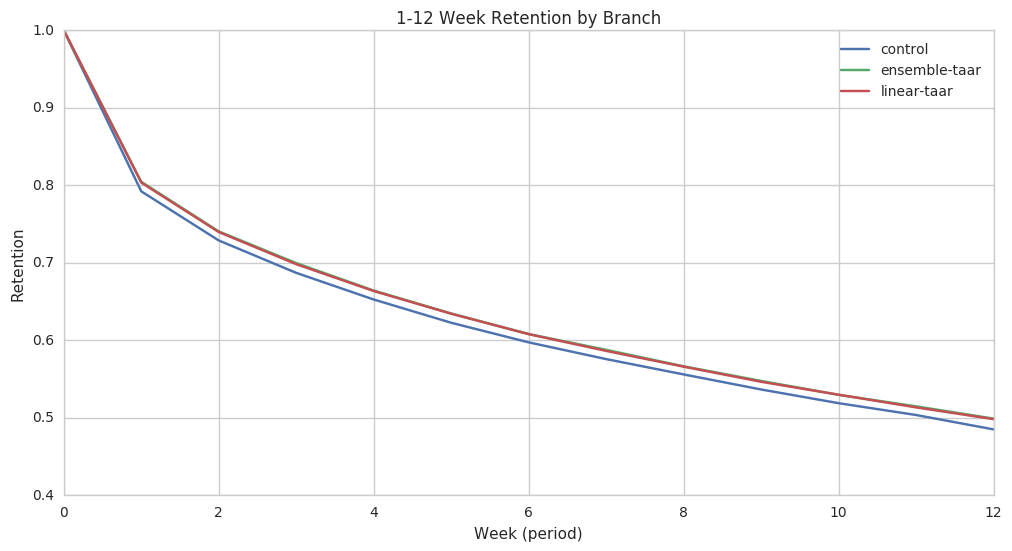

In [37]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in ret_df.groupby("branch"):
    (data.sort_values("period")
         .plot(x='period', 
               y='retention', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Week (period)")
plt.title("1-12 Week Retention by Branch")
plt.show()

In [38]:
ret_df[ret_df.period >= 6.0].sort_values(["period", "branch"])

,branch,period,n_week_clients,total_clients,retention
20,control,6.0,83578,139913,0.597357
9,ensemble-taar,6.0,65909,108381,0.608123
38,linear-taar,6.0,65698,108071,0.607915
17,control,7.0,80556,139913,0.575758
5,ensemble-taar,7.0,63699,108381,0.587732
32,linear-taar,7.0,63363,108071,0.586309
21,control,8.0,77789,139913,0.555981
12,ensemble-taar,8.0,61393,108381,0.566455
34,linear-taar,8.0,61164,108071,0.565961
14,control,9.0,75070,139913,0.536548


# Investigate nearly identical retention lines for TAAR Branches

Let's look at 6-week retention over time by each enrollment date

In [39]:
day_over_day_retention = []
for i in range(40):
    d = date_plus_x_days("20180312", i)
    joinedx = joined.filter("enrollment_date = '{}'".format(d))
    ret_dfx = get_retention(joinedx)
    week6 = ret_dfx[ret_dfx.period == 6.0]
    for b, data in week6.groupby("branch"):
        x = {
            'branch': b,
            'ret': data['retention'].values[0],
            'date': d
        }
        day_over_day_retention.append(x)

/mnt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


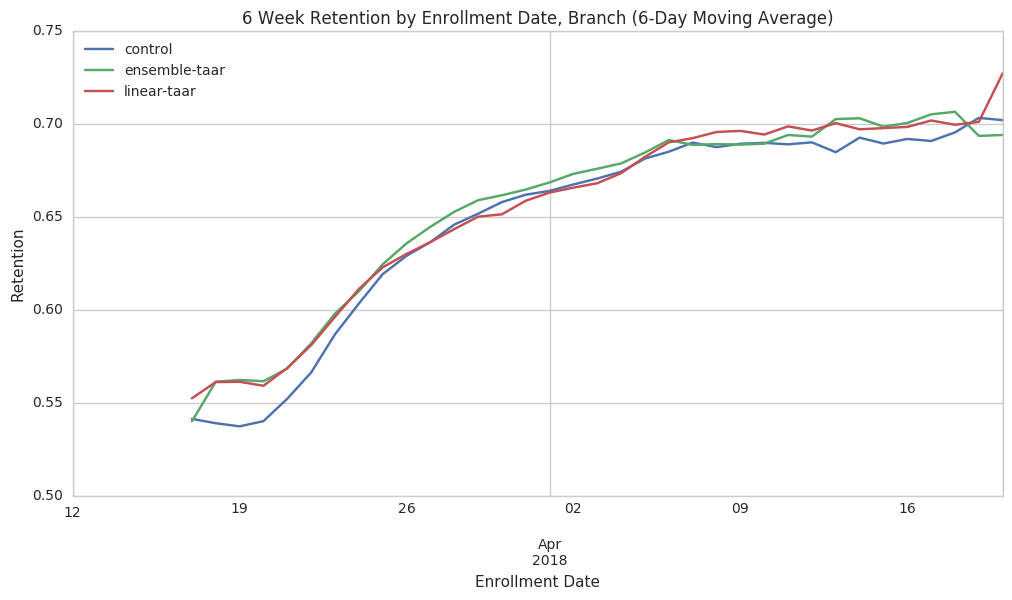

In [49]:
day_over_day_retention_df = pd.DataFrame(day_over_day_retention)
day_over_day_retention_df.date = (
    pd.to_datetime(day_over_day_retention_df.date, format='%Y%m%d'))

plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in day_over_day_retention_df.groupby("branch"):
    data['ma'] = data.ret.rolling(window=6).mean()
    (data.sort_values("date")
         .plot(x='date', 
               y='ma', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Enrollment Date")
plt.title("6 Week Retention by Enrollment Date, Branch (6-Day Moving Average)")
plt.show()

We see increased variability with time, which is most certainly due to the study being front-loaded with participants. Looking at enrollment:

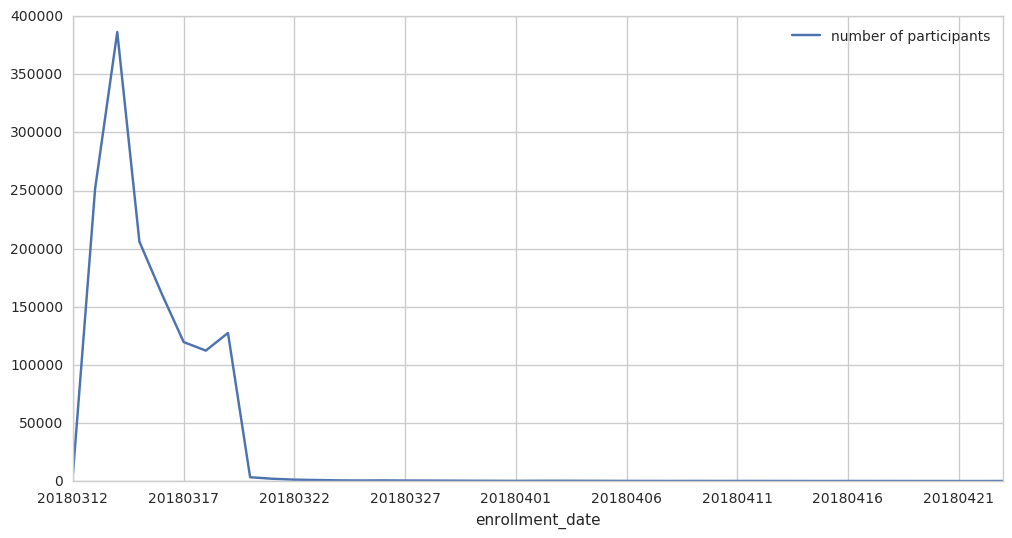

In [40]:
(joined.groupby("enrollment_date")
       .agg(F.countDistinct("client_id").alias("number of participants"))
       .sort("enrollment_date")
       .toPandas()
       .plot(x='enrollment_date'))

we see most of our clients are enrolled before 2018-03-22. This is why the lines are so smooth for the first ~9 datapoints in the previous retention chart


Breaking retention down into shorter segments shows that there are indeed differences between the taar branches, however they track each other rather closely and are consistently higher than the control. This is evidence that the similarities we see in the lines for the first plot are in fact the true retention values and not a data-handling issue.

# Results

In [79]:
w6r = ret_df[ret_df.period==6]
w6r

,branch,period,n_week_clients,total_clients,retention
9,ensemble-taar,6.0,65909,108381,0.608123
20,control,6.0,83578,139913,0.597357
38,linear-taar,6.0,65698,108071,0.607915


In [100]:
(slinear, nlinear,
 sensemble, nensemble,
 scontrol, ncontrol) = [int(w6r[w6r.branch == b][i].values[0])
                        for b in ('linear-taar', 'ensemble-taar', 'control')
                        for i in ('n_week_clients', "total_clients")]



In [118]:
def get_effect(g1s, g2s, g1n, g2n):
    """
    Extracts the observed difference and p-value 
    for two proportions
    
    g1s: the number of successes for group 1
    g2s: the number of successes for group 2
    g1n: total trials for group 1
    g2n: total trials for group 2
    
    returns the effect and p-value as a tuple
    """
    # use counts to form a proportion and format
    effect = str(round((g1s*1.0 / g1n) - (g2s*1.0 / g2n), 4) * 100) + '%'
    
    # perform test of proportions
    pval = sm.stats.proportions_ztest(np.array([g1s, g2s]),
                               np.array([g1n, g2n]),
                               value=0.05)[1]
    return effect, pval

In [119]:
le, lp = get_effect(slinear, scontrol, nlinear, ncontrol)  
print "linear effect: {}\npvalue: {}\n".format(le, lp)

ee, ep = get_effect(sensemble, scontrol, nensemble, ncontrol)  
print "ensemble effect: {}\npvalue: {}".format(ee, ep)


linear effect: 1.06%
pvalue: 4.34802206697e-88

ensemble effect: 1.08%
pvalue: 2.51189892932e-87
